# Scenerio
In the television documentary “Ross Kemp and the Armed Police” broadcast 6th September 2018 by ITV, multiple claims were made regarding violent crime in the UK.

These claims were:

1. Violent Crime is increasing.
2. There are more firearms incidents per head in Birmingham than anywhere else in the UK.
3. Crimes involving firearms are closely associated with drugs offences.

# 1. Introduction

## 1.1 Datasets Used
1. crimes data: This is the primary dataset used for this analysis, it has crime records in UK from 2010 to 2018. It has about 47 million records. It is publicly available at https://data.police.uk/data/ .
2. Population data by LSOA: a dataset that contains LSOA codes and various population information.
3. English Indices of Deprivation: This dataset contains detailed information about the cities found in UK, pulblicly available on  https://www.gov.uk/government/statistics/english-indices-of-deprivation-2019 .


## 1.2 Tools
Apache spark syntaxes through python API (Pyspark) were used most of the time. Python syntaxes were majorly used when pyspark dataframes were converted to pandas dataframes. The python libraries used were Numpy, Pandas, Matplotlib, Seaborn.

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession\
.builder\
.appName("Crimes_large")\
.config("spark.some.config.option", "some-value")\
.getOrCreate()

In [2]:
spark

To be able to use spark Dataframe in python, an entry point needs to be established. This entry point is called Spark Session (represented as "spark" in the codes below).

A SparkSession can be used to create DataFrame, register DataFrame as tables, execute SQL over tables, cache tables, and read parquet files.

# 2 Data Importation

In [22]:
## Import crime data 
df = spark.read.load("all_crimes18_hdr.txt", 
                         header = True, inferSchema = True, format = 'csv', sep = ',')

In [146]:
df.printSchemantSchema()

root
 |-- Crime ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)



The spark.read.load() function was used to load the data into the console. The header option was set to "True" in this section. The data already contained defined data types for each column(.printSchema() method was used to confirm), hence the need to set inferSchema as "True". format and sep were set as "csv" and "," respectively, because the file being imported is a delimited text file that used a comma to separate values.

In [23]:
## View first 5 records of crime using the .show() method
df.show(5)

+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|Crime ID|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|          Crime type|Last outcome category|Context|
+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|    null|2010-12|Avon and Somerset...|Avon and Somerset...|  -0.8056|51.819143|On or near Norfol...|E01017662| Aylesbury Vale 015C|         Other crime|                 null|   null|
|    null|2010-12|Avon and Somerset...|Avon and Somerset...|-2.494366|51.418169|On or near Keynsh...|E01014399|Bath and North Ea...|Anti-social behav...|                 null|   null|
|    null|2010-12|Avon and Somerset...|Avon and Somerset...|-2.511927|51.409435|

In [24]:
## View first 5 records of crime using the .head() method
df.head(5)

[Row(Crime ID=None, Month='2010-12', Reported by='Avon and Somerset Constabulary', Falls within='Avon and Somerset Constabulary', Longitude=-0.8056, Latitude=51.819143, Location='On or near Norfolk Terrace', LSOA code='E01017662', LSOA name='Aylesbury Vale 015C', Crime type='Other crime', Last outcome category=None, Context=None),
 Row(Crime ID=None, Month='2010-12', Reported by='Avon and Somerset Constabulary', Falls within='Avon and Somerset Constabulary', Longitude=-2.494366, Latitude=51.418169, Location='On or near Keynsham Road', LSOA code='E01014399', LSOA name='Bath and North East Somerset 001A', Crime type='Anti-social behaviour', Last outcome category=None, Context=None),
 Row(Crime ID=None, Month='2010-12', Reported by='Avon and Somerset Constabulary', Falls within='Avon and Somerset Constabulary', Longitude=-2.511927, Latitude=51.409435, Location='On or near Harlech Close', LSOA code='E01014399', LSOA name='Bath and North East Somerset 001A', Crime type='Anti-social behaviou

# 3. Data Cleaning

In [25]:
## View columns of crime
df.columns

['Crime ID',
 'Month',
 'Reported by',
 'Falls within',
 'Longitude',
 'Latitude',
 'Location',
 'LSOA code',
 'LSOA name',
 'Crime type',
 'Last outcome category',
 'Context']

The .columns attribute was used to check the column names of the data.

In [26]:
## How many records are in the dataset
df.count()

46986836

In [30]:
## Check for missing data in crime_s
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+--------+
|Crime ID|Month|Reported by|Falls within|Longitude|Latitude|Location|LSOA code|LSOA name|Crime type|Last outcome category| Context|
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+--------+
|19767343|    0|          0|           0|   598746|  598746|       0|  1717377|  1717377|         0|             21669569|46864431|
+--------+-----+-----------+------------+---------+--------+--------+---------+---------+----------+---------------------+--------+



Didn't clean anything...lol

# What are the unique crime_types?

In [31]:
df.select('crime type').distinct().show()

+--------------------+
|          crime type|
+--------------------+
|       Bicycle theft|
|        Public order|
|               Drugs|
|Public disorder a...|
|         Other crime|
|             Robbery|
|Criminal damage a...|
|Theft from the pe...|
|         Shoplifting|
|            Burglary|
|       Violent crime|
|         Other theft|
|Possession of wea...|
|Violence and sexu...|
|       Vehicle crime|
|Anti-social behav...|
+--------------------+



The .distinct() method selects unique records in specified column.

# 4. Exploratory Data Analysis

In [32]:
## Import Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

For visualization and Data Wrangling the following libraries were imported:

Pandas: Works on dataframes and used in manipulating data.

Numpy: Used in numerical and scientific computing.

Matplotlib: good at generating 2D graphs and Diagrams.

Seaborn: built on matplotlib, is best for visualizing statistical models

## What are the most committed crimes?

In [34]:
## The most committed crime types
df_count = df.groupBy('crime type').count()
df_count.orderBy(df_count['count'].desc()).show()

+--------------------+--------+
|          crime type|   count|
+--------------------+--------+
|Anti-social behav...|15876250|
|Violence and sexu...| 6133400|
|         Other theft| 3956921|
|Criminal damage a...| 3885799|
|            Burglary| 3408006|
|       Vehicle crime| 3051786|
|         Shoplifting| 2375662|
|         Other crime| 2271353|
|       Violent crime| 1673219|
|        Public order| 1319261|
|               Drugs| 1163898|
|       Bicycle theft|  502403|
|             Robbery|  490243|
|Theft from the pe...|  477465|
|Public disorder a...|  242145|
|Possession of wea...|  159025|
+--------------------+--------+



In [35]:
## Convert to Pandas DF
df_countpd = df_count.toPandas()
df_countpd

,crime type,count
0,Bicycle theft,502403
1,Public order,1319261
2,Drugs,1163898
3,Public disorder and weapons,242145
4,Other crime,2271353
5,Robbery,490243
6,Criminal damage and arson,3885799
7,Theft from the person,477465
8,Shoplifting,2375662
9,Burglary,3408006


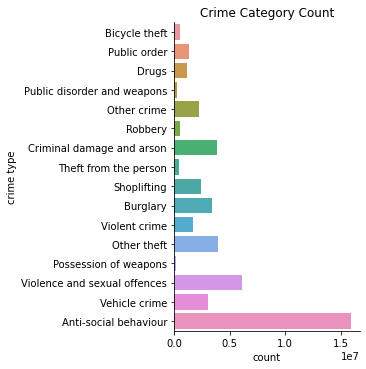

In [36]:
# Crime Type plot
sns.catplot(x= "count", y= "crime type",data = df_countpd, kind= "bar",ci=None).set(title = 'Crime Category Count')
plt.show()

The .groupBy() and .count() pair groups data by a certain categorical variable and counts the occurrence of individual class within that categorical variable. Secondly, the .orderBy() and .desc() method was used to order the crime_type count in a descending order, this revealed that the top 3 crime types in the dataset are 'Violence and sexual offences', 'Anti-social behaviour' and 'Other theft'. 'Anti-social behaviour' was the highest crime type with a total of 15876250 crime incidents.

To be able plot bar charts, the counts dataframe had to be converted from pyspark dataframe to pandas dataframe using the .toPandas() method since pyspark lacks visualization functions.

Finally, the catplot function from the Seaborn package was used to make bar plots for each crime type in both datasets.

## Are violent crimes increasing?
Violent crimes are crimes that involve harming or threatening a victim with violence. They include rape and sexual assault, robbery and murder. For the purpose of this task, I have categorised the following crime types from the dataset as violent:

1. Robbery
2. Violence and sexual offences

To answer this question, the following substasks were carried out:

1. Filter out the above crime types.
2. Create year column from the month column
3. GroupBy year and count.
4. Order the grouped data by month.
5. Convert the dataframe of ordered data to pandas dataframe.
6. Plot the data in a line plot to observe the trend of violent crimes.

In [38]:
# filter out robbery, and violence and sexual offences

vio_cr = df.filter((df['crime type'] == 'Robbery') | (df['crime type'] == 'Violence and sexual offences'))
vio_cr.show(5)

+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+----------+---------------------+-------+
|Crime ID|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|Crime type|Last outcome category|Context|
+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+----------+---------------------+-------+
|    null|2010-12|Avon and Somerset...|Avon and Somerset...|-2.511019|51.405366|On or near Oak Tr...|E01014402|Bath and North Ea...|   Robbery|                 null|   null|
|    null|2010-12|Avon and Somerset...|Avon and Somerset...|-2.361416|51.381448|On or near Westga...|E01014370|Bath and North Ea...|   Robbery|                 null|   null|
|    null|2010-12|Avon and Somerset...|Avon and Somerset...|-2.357056|51.378871|On or near Manver...|E01014371|Bath and North Ea..

.filter() method was used to filter out required crime types, the '|' symbol represents 'or', which translates to filter crime_type 'Robbery' or 'Violence and sexual offences'.

In [50]:
# create year column from month
from pyspark.sql.functions import year
viol_year = vio_cr.select(year(vio_cr['Month']))
viol_year.show(5)

+-----------+
|year(Month)|
+-----------+
|       2010|
|       2010|
|       2010|
|       2010|
|       2010|
+-----------+
only showing top 5 rows



In [54]:
## groupby year and count
viol_year_cnt = viol_year.groupBy('year(Month)').count().orderBy('year(Month)')

In [55]:
## Convert the counted data to pandas dataframe
viol_year_cntpd = viol_year_cnt.toPandas()
viol_year_cntpd.head()

,year(Month),count
0,2010,5731
1,2011,75068
2,2012,68042
3,2013,538361
4,2014,891937


Convert pyspark dataframe to pandas dataframe using .toPandas() method.

In [68]:
rolmean = viol_year_cntpd['count'].rolling(2).mean()

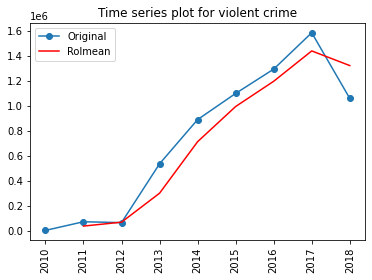

In [69]:
## Time series plot for violent crime
fig, ax = plt.subplots()
ax.plot(viol_year_cntpd['year(Month)'], viol_year_cntpd['count'], marker = 'o', label = 'Original')
ax.plot(viol_year_cntpd['year(Month)'], rolmean, color = 'r', label = 'Rolmean')
ax.set_title('Time series plot for violent crime')
ax.tick_params(axis='x', labelrotation = 90)
plt.legend(loc='best')
plt.show()

Rolling mean was applied to the time series plot to smooth out short-term fluctuations and highlight long-term trends. Apart from the basic line plot functions used, some options were added to rotate x-axis tick, add colours and labels

### Are there more firearms incidents per head in Birmingham than anywhere else in the UK?

To carry out this task I focused on the crime_type, "Possession of weapons". The subtasks include:

1. Filter out the crime type = "Possession of weapons".
2. Join the already filtered data with English Indices of Deprivation and Population data by LSOA.
3. Select only required columns.
4. Carry out groupBy and Sum operations on population variable in filtered data, to get total population per city.
5. Carry out groupBy and count on filtered data to get total fire arm incident per city
6. Join both grouped data.
7. Create new column to calculate Incident per head.
8. Orderby the newly created column in descending order

I assumed that weapons in the dataset is same as firearms.

In [70]:
## Filter for possession of weapon
fire = df.filter(df['crime type'] == 'Possession of weapons')
fire.show(5)

+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|            Crime ID|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|          Crime type|Last outcome category|Context|
+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|9c68ace1c9a77a7f4...|2013-05|Avon and Somerset...|Avon and Somerset...|-2.351833|51.398435|On or near Bay Tr...|E01014410|Bath and North Ea...|Possession of wea...| Offender given a ...|   null|
|05c3e05b387d09ced...|2013-05|Avon and Somerset...|Avon and Somerset...| -2.36554|51.388682|On or near Harley...|E01033080|Bath and North Ea...|Possession of wea...| Offender given co...|   null|
|86a6b4fa4cd295144..

In [72]:
# Join the fire arms dataset with the deprivation_hdr and LSOA_pop_v2 dataset
## Import the datasets
depr = spark.read.load("deprivation_with_hdr.csv", 
                         header = True, inferSchema = True, format = 'csv', sep = ',')
depr.head(2)[0]

Row(LSOA CODE='E01000001', PRE 2009 LA CODE='00AA', PRE 2009 LA NAME='City of London', POST 2009 LA CODE='00AA', POST 2009 LA NAME='City of London', GOR CODE='H', GOR NAME='London', IMD SCORE=6.16, RANK OF IMD SCORE (where 1 is most deprived)=28814, INCOME SCORE=0.01, RANK OF INCOME SCORE (where 1 is most deprived)=32460, EMPLOYMENT SCORE=0.01, RANK OF EMPLOYMENT SCORE (where 1 is most deprived)=32435, HEALTH DEPRIVATION AND DISABILITY SCORE=-2.11, RANK OF HEALTH DEPRIVATION AND DISABILITY SCORE (where 1 is most deprived)=32332, EDUCATION SKILLS AND TRAINING SCORE=0.21, RANK OF EDUCATION SKILLS AND TRAINING SCORE (where 1 is most deprived)=32421, BARRIERS TO HOUSING AND SERVICES SCORE=32.6, RANK OF BARRIERS TO HOUSING AND SERVICES SCORE (where 1 is most deprived)=5491, CRIME AND DISORDER SCORE=-1.64, RANK OF CRIME SCORE (where 1 is most deprived)=31816, LIVING ENVIRONMENT SCORE=26.28, RANK OF LIVING ENVIRONMENT SCORE (where 1 is most deprived)=10212, Indoors Sub-domain Score=20.76, Ind

In [73]:
lsoa_pop = spark.read.load("LSOA_pop_v2.csv", 
                         header = True, inferSchema = True, format = 'csv', sep = ',')
lsoa_pop.head(2)[0]

Row(date=2011, geography='Darlington 001B', geography code='E01012334', Rural Urban='Total', Variable: All usual residents; measures: Value=2466, Variable: Males; measures: Value=1220, Variable: Females; measures: Value=1246, Variable: Lives in a household; measures: Value=2466, Variable: Lives in a communal establishment; measures: Value=0, Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value=42, Variable: Area (Hectares); measures: Value=6033.58, Variable: Density (number of persons per hectare); measures: Value=0.4)

In [77]:
## Rename the columns needed to join dataset and some other columns
depr_2 = depr.withColumnRenamed('PRE 2009 LA NAME', 'City_name')
lsoa_pop_2 = lsoa_pop.withColumnRenamed('geography code', 'LSOA code').withColumnRenamed('Variable: All usual residents; measures: Value', 'Population')

Since the datasets will be joined on the LSOA code, it makes sense to rename the corresponding columns of the newly imported datasets. The .withColumnRenamed() method was used for this purpose.

In [78]:
## Join the 3 datasets
join_ = fire.join(depr_2, on = ['LSOA code'], how = 'left').join(lsoa_pop_2, on = ['LSOA code'], how = 'left')

##Inspect the columns
join_.columns

['LSOA code',
 'Crime ID',
 'Month',
 'Reported by',
 'Falls within',
 'Longitude',
 'Latitude',
 'Location',
 'LSOA name',
 'Crime type',
 'Last outcome category',
 'Context',
 'PRE 2009 LA CODE',
 'City_name',
 'POST 2009 LA CODE',
 'POST 2009 LA NAME',
 'GOR CODE',
 'GOR NAME',
 'IMD SCORE',
 'RANK OF IMD SCORE (where 1 is most deprived)',
 'INCOME SCORE',
 'RANK OF INCOME SCORE (where 1 is most deprived)',
 'EMPLOYMENT SCORE',
 'RANK OF EMPLOYMENT SCORE (where 1 is most deprived)',
 'HEALTH DEPRIVATION AND DISABILITY SCORE',
 'RANK OF HEALTH DEPRIVATION AND DISABILITY SCORE (where 1 is most deprived)',
 'EDUCATION SKILLS AND TRAINING SCORE',
 'RANK OF EDUCATION SKILLS AND TRAINING SCORE (where 1 is most deprived)',
 'BARRIERS TO HOUSING AND SERVICES SCORE',
 'RANK OF BARRIERS TO HOUSING AND SERVICES SCORE (where 1 is most deprived)',
 'CRIME AND DISORDER SCORE',
 'RANK OF CRIME SCORE (where 1 is most deprived)',
 'LIVING ENVIRONMENT SCORE',
 'RANK OF LIVING ENVIRONMENT SCORE (where

The three Datasets were left joined on the LSOA_code column. The .columns attribute was used to display all the columns of the joined datasets. Alot of useless columns right?


In [79]:
## Select only useful columns
join_final = join_.select(['LSOA code','Month','City_name','Population'])
join_final.show()

+---------+-------+--------------------+----------+
|LSOA code|  Month|           City_name|Population|
+---------+-------+--------------------+----------+
|E01014410|2013-05|Bath and North Ea...|      1770|
|E01033080|2013-05|                null|      2205|
|E01014602|2013-05|    Bristol, City of|      1841|
|E01014638|2013-05|    Bristol, City of|      1624|
|E01014636|2013-05|    Bristol, City of|      1496|
|E01014642|2013-05|    Bristol, City of|      1449|
|E01014618|2013-05|    Bristol, City of|      1547|
|E01014508|2013-05|    Bristol, City of|      1722|
|E01014624|2013-05|    Bristol, City of|      1738|
|E01014629|2013-05|    Bristol, City of|      1477|
|E01014485|2013-05|    Bristol, City of|      1817|
|E01014489|2013-05|    Bristol, City of|      2403|
|E01014551|2013-05|    Bristol, City of|      1781|
|E01014531|2013-05|    Bristol, City of|      1661|
|E01014536|2013-05|    Bristol, City of|      1437|
|E01014581|2013-05|    Bristol, City of|      1529|
|E01014655|2

In [80]:
## Sum the the population and group by city 
sum_ = join_final.groupBy('City_name').sum('Population')
## Count the cities with the highest weapons crime
cnt = join_final.groupBy('City_name').count()

groupBy() and .sum() pair were used to get total population by city.

groupBy() and .count() pair were used to get crime incident count by city.

In [81]:
## join both count and sum tables
cnt_sum = sum_.join(cnt, on = ['City_name'], how = 'left')
cnt_sum.show()

+---------------+---------------+-----+
|      City_name|sum(Population)|count|
+---------------+---------------+-----+
|North Wiltshire|         215331|  133|
|      Worcester|         386707|  242|
|      Charnwood|         570329|  323|
| North Kesteven|         115353|   68|
|           Arun|         736921|  437|
|  Epping Forest|         436337|  263|
|        Waveney|         453110|  285|
| North Cornwall|         214065|  127|
|         Stroud|         182027|   96|
|         Maldon|         112011|   70|
|     New Forest|         456950|  290|
|      Sedgemoor|         235882|  143|
|      Guildford|         478571|  277|
|St. Edmundsbury|         437669|  242|
|       Worthing|         694973|  396|
|        Fareham|         252658|  161|
|         Bolton|        1459160|  900|
| North Tyneside|         922030|  594|
|   Surrey Heath|         148113|   94|
| Wellingborough|         466188|  288|
+---------------+---------------+-----+
only showing top 20 rows



In [82]:
## Create column to get incident per head
wph = cnt_sum.withColumn('Weapon_per_head', cnt_sum['count']/cnt_sum['sum(Population)'])
wph.show()

+---------------+---------------+-----+--------------------+
|      City_name|sum(Population)|count|     Weapon_per_head|
+---------------+---------------+-----+--------------------+
|North Wiltshire|         215331|  133|6.176537516660398E-4|
|      Worcester|         386707|  242|6.257967918863635E-4|
|      Charnwood|         570329|  323|5.663397793203572E-4|
| North Kesteven|         115353|   68|5.894948549235824E-4|
|           Arun|         736921|  437|5.930079343647419E-4|
|  Epping Forest|         436337|  263|6.027451259003935E-4|
|        Waveney|         453110|  285|6.289863388581139E-4|
| North Cornwall|         214065|  127|5.932777427416907E-4|
|         Stroud|         182027|   96|5.273942876606218E-4|
|         Maldon|         112011|   70|6.249386220996152E-4|
|     New Forest|         456950|  290|6.346427399058978E-4|
|      Sedgemoor|         235882|  143|6.062353210503557E-4|
|      Guildford|         478571|  277|5.788064884834225E-4|
|St. Edmundsbury|       

To create weapons_per_head column for each city, the count columns had to be divided by the population column.

In [83]:
## Orderby Weapon per head in descending order
wph.orderBy(wph['Weapon_per_head'].desc()).show()

+-----------------+---------------+-----+--------------------+
|        City_name|sum(Population)|count|     Weapon_per_head|
+-----------------+---------------+-----+--------------------+
|   City of London|          32874|   27| 8.21317758715094E-4|
|Barrow-in-Furness|         296128|  216|7.294143073265615E-4|
|         Copeland|         163331|  115|7.040916911057913E-4|
|         Oswestry|          78234|   55|7.030191476851496E-4|
|            Corby|         394617|  273|6.918100335261785E-4|
|        Easington|         235032|  162|6.892678443786378E-4|
|            Fylde|          75577|   52|6.880400121730156E-4|
|    Ribble Valley|          33602|   23|6.844830664841378E-4|
|   North Somerset|         407791|  278|6.817217643351619E-4|
|         Teesdale|          35272|   24|6.804264005443411E-4|
|           Sefton|         842201|  573|  6.8036015155527E-4|
|          Caradon|         125131|   85|6.792881060648441E-4|
|   South Tyneside|         789667|  536|6.787671258897

Finally order the dataset by weapon_per_head column in descending order to find out the city with highest firearm incident per head

In [84]:
# Orderby count
wph.orderBy(wph['count'].desc()).show()

+-------------------+---------------+-----+--------------------+
|          City_name|sum(Population)|count|     Weapon_per_head|
+-------------------+---------------+-----+--------------------+
|         Birmingham|        5185650| 3051|5.883544010876168E-4|
|         Manchester|        4935230| 2655|5.379688484629895E-4|
|         Uttlesford|        5955629| 2540|4.264872778341297E-4|
|              Leeds|        2915391| 1804|6.187849245607193E-4|
|          Sheffield|        2729002| 1674|6.134110564961111E-4|
|            Lambeth|        2861353| 1631|5.700100616736209E-4|
|        Westminster|        2853365| 1502| 5.26396027146895E-4|
|         Nottingham|        2568980| 1489|5.796074706692929E-4|
|           Bradford|        2629308| 1468|  5.5832180938863E-4|
|          Liverpool|        2407203| 1394|5.790953234936978E-4|
|           Kirklees|        2219397| 1249| 5.62765471882678E-4|
|  Brighton and Hove|        2145202| 1248|5.817633957081897E-4|
|            Croydon|    

Also order by count, to find out the city with the highest crime rate

### Are Crimes involving firearms closely associated with drugs offences?
To solve this task, the correlation coefficient between both crime types must be calculated. The sub tasks are as follows:

1. Filter out drug and firearms crime type separately.
2. Group and count both crime types by month.
3. Join both tables and order by month.
4. Find the correlation coefficient of both count variables.
5. Plot the data.

In [88]:
## Filter crime type = Drugs
dr = df.filter(df['crime type'] == 'Drugs')
dr.show(3)

+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+----------+---------------------+-------+
|Crime ID|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|Crime type|Last outcome category|Context|
+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+----------+---------------------+-------+
|    null|2011-09|Avon and Somerset...|Avon and Somerset...|   -2.507|51.408557|On or near Tenby ...|E01014404|Bath and North Ea...|     Drugs|                 null|   null|
|    null|2011-09|Avon and Somerset...|Avon and Somerset...|-2.492186|51.413386|On or near Dragon...|E01014396|Bath and North Ea...|     Drugs|                 null|   null|
|    null|2011-09|Avon and Somerset...|Avon and Somerset...|-2.483019|51.412705|On or near Bath Road|E01014398|Bath and North Ea..

In [144]:
# Group the filtered fire arm table by month and count the number of incidents in each month
fire_mon = fire.groupBy('month').count().withColumnRenamed('count', 'count_fire').orderBy('month')
fire_mon.show(5)

+-------+----------+
|  month|count_fire|
+-------+----------+
|2013-05|      1810|
|2013-06|      1735|
|2013-07|      1939|
|2013-08|      1836|
|2013-09|      1767|
+-------+----------+
only showing top 5 rows



In [145]:
# Group the filtered drug table by month and count the number of incidents in each month
drug_mon = dr.groupBy('month').count().withColumnRenamed('count', 'count_drug').orderBy('month')
drug_mon.show(5)

+-------+----------+
|  month|count_drug|
+-------+----------+
|2011-09|     16926|
|2011-10|     18448|
|2011-11|     18267|
|2011-12|     17366|
|2012-01|     18199|
+-------+----------+
only showing top 5 rows



In [122]:
## Use inner join to merge both tables using month as the column
drug_fire_mon = drug_mon.join(fire_mon, on = ('month'), how = 'inner').orderBy('month')
drug_fire_mon.show(5)

+-------+----------+----------+
|  month|count_drug|count_fire|
+-------+----------+----------+
|2013-05|     17128|      1810|
|2013-06|     16685|      1735|
|2013-07|     16793|      1939|
|2013-08|     16290|      1836|
|2013-09|     15128|      1767|
+-------+----------+----------+
only showing top 5 rows



In [128]:
## Create a new column to extra year from the month column
drug_fire_mon2 = drug_fire_mon.withColumn(('Year'), year(drug_fire_mon['month']))
drug_fire_mon2.show(5)

+-------+----------+----------+----+
|  month|count_drug|count_fire|Year|
+-------+----------+----------+----+
|2013-05|     17128|      1810|2013|
|2013-06|     16685|      1735|2013|
|2013-07|     16793|      1939|2013|
|2013-08|     16290|      1836|2013|
|2013-09|     15128|      1767|2013|
+-------+----------+----------+----+
only showing top 5 rows



The year function imported earlier was used to create an extra column to indicate the year each month belonged to.

In [129]:
## Convert the joined dataset to pandas dataframe
drug_firepd = drug_fire_mon2.toPandas()
drug_firepd.head(5)

,month,count_drug,count_fire,Year
0,2013-05,17128,1810,2013
1,2013-06,16685,1735,2013
2,2013-07,16793,1939,2013
3,2013-08,16290,1836,2013
4,2013-09,15128,1767,2013


In [141]:
drug_firepd['Year'] = drug_firepd['Year'].astype('category') # convert the new column to a categorical variable

In [142]:
## Correlation  of count_fire and count dr
np.corrcoef(drug_firepd['count_fire'], drug_firepd['count_drug'])

array([[ 1.        , -0.68078167],
       [-0.68078167,  1.        ]])

The corrcoef() function from Numpy library was used to create a correlation coefficient between both count variables over the year.

C:\Users\Kelvin\Anaconda3\envs\Data_science\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


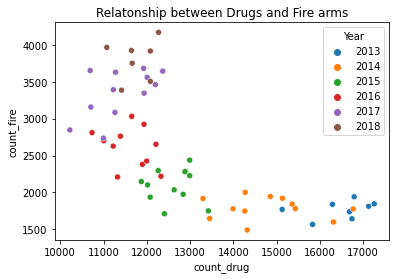

In [143]:
## Plot the relationship
sns.scatterplot('count_drug','count_fire', data = drug_firepd, hue = 'Year').set(title = 'Relatonship between Drugs and Fire arms')
plt.show()

The scatterplot function from seaborn library was used to plot the relationship between Drugs and Fire arms crime count from 2013 to 2018

# 5. Conclusion
Results from the detailed analysis above answers the following questions:

1. Are violent crimes increasing?
There was a slight increase in violent crimes from 2010 but dropped just a little in 2012, after which violent crimes started increasing signficantly upto to 2017 where it decreased abruptly almost to same level where it was in 2015, this is suspected to be caused by incomplete data collected in 2018 where the crimes record stopped at July. The low crime rates before 2013 can be attributed to the fact that some crime categories were missing in those years. Excluding years before 2013 and 2018, it is safe to agree with Ross Kemp on this particular claim

2. Are there more firearms incidents per head in Birmingham than anywhere else in the UK?
Analysis from the dataset reveals that Birmingham is the top city with the most fire arms incident in UK. However a closer look at the dataset falsifies Ross'claim. Due to the large number of people living in Birmingham, the firearm per head rate has dropped drastically over the years.

3. Are Crimes involving firearms closely associated with drugs offences?
Analysis shows that there is a negative correlation between fire arms crimes and drugs related crimes which again falsifies Ross' claim. But looking at the shape of the graph, focusing on the top left corner, there seem to be a trend formed by the recent years (2017 and 2018), which shows a little positive relationship between both crime types. If this trends continues in the future there would be a strong association between drugs and firearms crimes.